In [1]:
import numpy as np
import torch
import cv2
import sys

from vq_vae.auto_encoder import *

# load pretrained VQ-VAE to serve as a feature extractor
# Since VQ-VAE can binarize an image into features and does not
# lose too much information.
# now we're going to train VQ-VAE on FashionMNIST, CIFAR10, MINI-IMAGENET
# to verify our ideas of generalization.

# check pretrained VA-VQE on MNIST
net_mnist = VQ_CVAE(64, 10, num_channels=1)
net_mnist.load_state_dict(torch.load('results/2022-12-10_17-20-26/checkpoints/model_99.pth'))

<All keys matched successfully>

In [2]:
import torchvision as tv

data_mnist = tv.datasets.MNIST('../data/mnist/', train=False)
im_digits = [list() for _ in range(10)]
for _im, _digit in data_mnist:
    im_digits[_digit].append(np.array(_im))
im_digits = [np.stack(im_digits[i]) for i in range(len(im_digits))]
for i in range(len(im_digits)):
    print(im_digits[i].shape)

(980, 28, 28)
(1135, 28, 28)
(1032, 28, 28)
(1010, 28, 28)
(982, 28, 28)
(892, 28, 28)
(958, 28, 28)
(1028, 28, 28)
(974, 28, 28)
(1009, 28, 28)


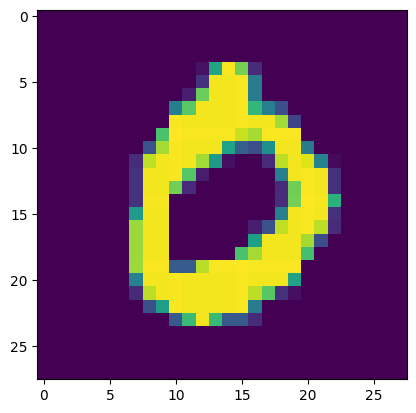

In [3]:
import matplotlib.pyplot as plt

plt.imshow(im_digits[0][0])

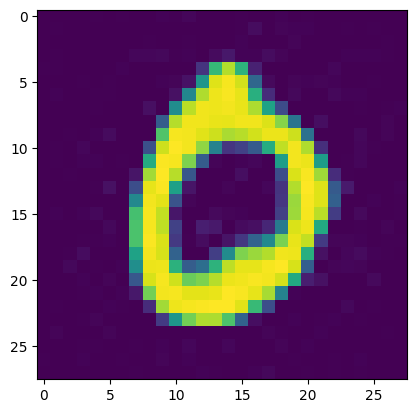

In [4]:
x =  torch.from_numpy(np.float32(im_digits[0][0].reshape([1,1,28,28]))/255.0)
net_mnist.train(False)
x_r, z_e, emb, argmin = net_mnist(x)
im_r = np.uint8(np.clip(x_r.detach().numpy()[0][0], 0, 1)*255)
plt.imshow(im_r)

In [5]:
print(z_e.shape)
print(emb.shape)
print(argmin)
print(z_e[0,0])
print(emb[0,0])

torch.Size([1, 64, 7, 7])
torch.Size([1, 64, 7, 7])
tensor([[[2, 2, 6, 6, 2, 2, 2],
         [2, 6, 7, 1, 0, 2, 2],
         [2, 7, 1, 4, 1, 0, 2],
         [2, 3, 5, 2, 8, 4, 2],
         [2, 8, 5, 3, 8, 9, 2],
         [2, 3, 1, 1, 5, 6, 2],
         [2, 2, 0, 0, 2, 2, 2]]])
tensor([[-0.2120, -0.2118, -0.1584, -0.2180, -0.1982, -0.2150, -0.2176],
        [-0.2148, -0.2009, -0.1030,  0.2653, -0.0330, -0.2259, -0.2158],
        [-0.2194, -0.1486,  0.2215,  0.3513,  0.3003, -0.1171, -0.2002],
        [-0.1887,  0.1083,  0.3816,  0.1787, -0.0007,  0.4538, -0.2408],
        [-0.2048,  0.3327,  0.0015, -0.0244,  0.2732,  0.2299, -0.1945],
        [-0.1899,  0.1812,  0.3779,  0.4175,  0.2797, -0.2234, -0.2126],
        [-0.2154, -0.1776, -0.0737,  0.0547, -0.2290, -0.2134, -0.2138]],
       grad_fn=<SelectBackward0>)
tensor([[-0.2139, -0.2139, -0.1772, -0.1772, -0.2139, -0.2139, -0.2139],
        [-0.2139, -0.1772, -0.1212,  0.2959, -0.0394, -0.2139, -0.2139],
        [-0.2139, -0.1212,  0.

[0 1 2 3 4 5 6 7 8 9]
[ 4  5 22  3  2  3  4  2  3  1]


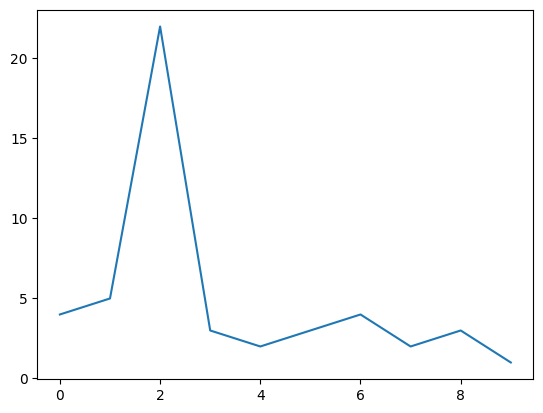

In [6]:
# check statistic features on encoded discretized vectors
code = argmin.view(-1).detach().numpy()
hist, bins = np.histogram(code, bins=np.arange(11))
bins = bins[:-1]
print(bins)
print(hist)
plt.plot(bins, hist)

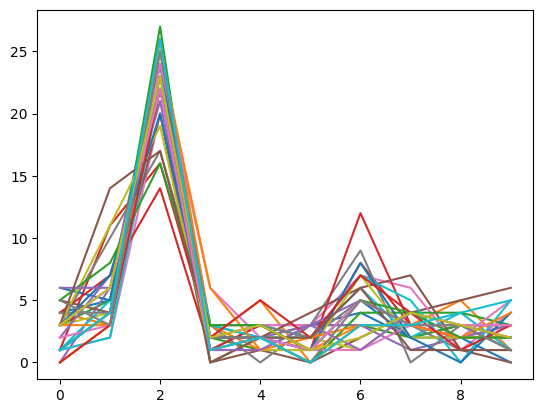

In [25]:
def calcHist(x, splits:list)->list:
    hist = [0] * len(splits)
    for i in x:
        assert i == int(i)
        assert i <= len(splits)
        hist[int(i)] += 1
    return hist


# count on all images of the same digit
size = 30
nclass = 10
digit_id = 0
bins = np.arange(nclass)
fig = plt.figure()

net_mnist.train(False)
for i in range(size):
    x =  torch.from_numpy(np.float32(im_digits[digit_id][i].reshape([1,1,28,28]))/255.0)
    x_r, z_e, emb, argmins = net_mnist(x)
    #plt.imshow(np.concatenate([im_digits[digit_id][i], np.uint8(np.clip(x_r.detach().numpy()[0][0],0,1)*255)], axis=1))
    #plt.show()
    code = argmins.view(-1).detach().numpy()
    hist = calcHist(code, np.arange(0, nclass))
    #print(code)
    plt.plot(bins, hist)
    #plt.show()
plt.show()

In [93]:
# the features may be spatially sensitive
size = 100
digit_id = 5
net_mnist.train(False)
codes = []
for i in range(size):
    x =  torch.from_numpy(np.float32(im_digits[digit_id][i].reshape([1,1,28,28]))/255.0)
    x_r, z_e, emb, argmins = net_mnist(x)
    code = argmins.view(-1).detach().numpy()
    #print(code)
    codes.append(code)
codes = np.array(codes)
print(codes.shape)

(100, 49)


In [94]:
mask = [True] * codes.shape[1]
feats = codes[0]
for i in range(codes.shape[0]):
    mask = np.logical_and(mask, codes[i]==feats)
    feats = mask * feats
print(mask.sum())
print(feats)

4
[2 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 2 0 0 0 0 0 2]
